# T1 de NoIA

Neste trabalho, vamos aprender a implementar o algoritmo de redes neurais de aprendizado de máquina (ANN) para a tarefa de classificação de imagens de maneira mais eficiente. Vamos passar pelas várias técnicas de implementação que foram utilizadas ao longo do desenvolvimento e a evolução da tecnologia.

## Alunos
- **Arthur de Sá Antero - 212006577**
- **Arthur Mota Furtado - 200014935**

## Importações

Neste trabalho, utilizaremos a biblioteca [d2l](https://github.com/d2l-ai/d2l-en) para implementar o algoritmo de redes neurais. A biblioteca d2l é uma biblioteca de aprendizado de máquina de alto nível, desenvolvida pela DeepMind. Ela fornece uma interface amigável para a implementação de modelos de redes neurais, incluindo o uso de GPUs para acelerar o processo de treinamento.
Nos também utilizaremos a biblioteca tensorflow para fornecer as funções de redes neurais, matplotlib para visualizar os resultados, sklearn para realizar o treinamento e validação dos modelos, e pdb para depurar o código.


In [25]:
import tensorflow as tf
from d2l import tensorflow as d2l
d2l.use_svg_display()
import pdb
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.metrics import confusion_matrix
import statistics

## Base de dados

A base de dados é um conjunto de dados de treinamento e teste que serão utilizados para treinar e avaliar o modelo. Neste caso, vamos utilizar o conjunto de dados de teste do MNIST, que é um conjunto de imagens de tamanho 28x28 e de número de classes 10.

In [26]:
class MNIST(d2l.DataModule): #@save
    """The MNIST dataset."""
    def __init__(self, batch_size=64):
        super().__init__()
        self.save_hyperparameters()
        self.train, self.val = tf.keras.datasets.mnist.load_data()

In [27]:
data = MNIST()
print(len(data.train[0]), len(data.val[0]))
print(data.train[0].shape)

60000 10000
(60000, 28, 28)


Para podermos usar o d2l para o treinamento temos que definir o dataloader que divide o dataset em batchs e o modelo que irá receber os dados e fazer a predição.

In [28]:
@d2l.add_to_class(MNIST) #@save
def get_dataloader(self, train):
    data = self.train if train else self.val
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255, tf.cast(y, dtype='int32'))
    self.resize_fn = lambda X, y: (tf.image.resize_with_pad(X, *self.resize), y)
    shuffle_buf = len(data[0]) if train else 1
    return tf.data.Dataset.from_tensor_slices(process(*data)).batch(self.batch_size).shuffle(shuffle_buf)

@d2l.add_to_class(MNIST)  #@save
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(tf.squeeze(X), nrows, ncols, titles=labels)

In [29]:
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

(64, 28, 28, 1) <dtype: 'float32'> (64,) <dtype: 'int32'>


## Modelo básico perceptron

Aqui definimos a nossa primeira versão do modelo perceptron. O modelo perceptron é um modelo de classificação simples que é capaz de classificar dados de entrada em uma classe de saída. Neste caso é um modelo bem simples, com uma camada que transforma a matrix da entrada em um vetor (flatten), uma camada oculta e uma camada de saída, ambas usando a função sigmoide.

In [30]:
class MLPSigmoid(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='sigmoid'),
            tf.keras.layers.Dense(num_outputs, activation='sigmoid')])
        self.loss_fn=tf.keras.losses.MeanSquaredError
        self.optimizer=tf.keras.optimizers.SGD

Para podermos ter resultados o mais precisos, vamos realizar o treino 5 vezes e usar a média dos resultados para definirmos o erro médio do modelo usado.

0.9065


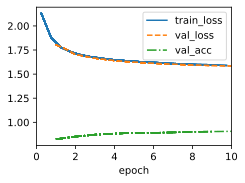

In [31]:
sigmoid_model = MLPSigmoid(num_outputs=10, num_hiddens=128, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(sigmoid_model, data)
print(d2l.evaluate_accuracy(sigmoid_model, data.val_dataloader()))

## Perceptron com saída softmax

O nosso próximo modelo será um perceptron com uma saída softmax. Como mudamos a saída para o resultado esperado, e não uma saída "one-hot", também mudamos o erro para o modelo de entropia cruzada.

In [32]:
class MLPSoftMax(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='sigmoid'),
            tf.keras.layers.Dense(num_outputs, activation='softmax')])
        self.loss_fn=tf.keras.losses.SparseCategoricalCrossentropy
        self.optimizer=tf.keras.optimizers.SGD

Novamente, vamos rodar o modelo 5 vezes para conseguirmos a acurácia média.

0.7657


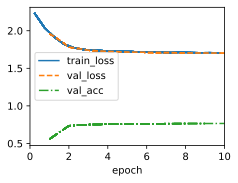

In [33]:
soft_model = MLPSoftMax(num_outputs=10, num_hiddens=128, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(soft_model, data)
print(d2l.evaluate_accuracy(soft_model, data.val_dataloader()))

## Otimizador Adam

Com o desenvolvimento dos modelos de machine learning, diferentes propostas de otimizadores de gradiente foram desenvolvidas. Uma das mais famosas é o otimizador Adam, que é uma extensão do otimizador SGD (Stochastic Gradient Descent). O SGD é um otimizador de gradiente que atualiza os pesos da rede de forma a minimizar a função de perda. O Adam é um otimizador que atualiza os pesos da rede de forma a minimizar a função de perda, mas com uma variação na atualização dos pesos.

In [34]:
class MLPAdam(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='sigmoid'),
            tf.keras.layers.Dense(num_outputs, activation='softmax')])
        self.loss_fn=tf.keras.losses.SparseCategoricalCrossentropy
        self.optimizer=tf.keras.optimizers.Adam

Novamente, para certificar a acurácia do modelo, vamos treiná-lo 5 vezes, e calcular a média de acurácia.

0.833


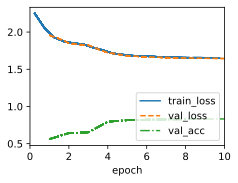

In [35]:
adam_model = MLPAdam(num_outputs=10, num_hiddens=128, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(adam_model, data)
print(d2l.evaluate_accuracy(adam_model, data.val_dataloader()))

## Função Relu

Um desenvolvimento inesperado, mas que é muito interessante, é a função relu. A função relu é uma função que recebe um valor e retorna o mesmo valor se ele for positivo ou zero se ele for negativo. E ela já da não linearidade o suficiente para ser usada como uma função de ativação.

In [36]:
class MLPRelu(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='relu'),
            tf.keras.layers.Dense(num_outputs, activation='softmax')])
        self.loss_fn=tf.keras.losses.SparseCategoricalCrossentropy
        self.optimizer=tf.keras.optimizers.Adam

0.9455


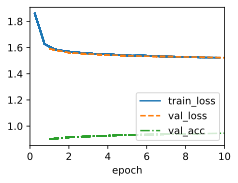

In [37]:

relu_model = MLPRelu(num_outputs=10, num_hiddens=128, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(relu_model, data)
print(d2l.evaluate_accuracy(relu_model, data.val_dataloader()))

## Rede com 256 neurônios escondidos

Agora que aplicamos vários modelos que diminuem o tempo de treinamento, vamos tentar uma implementação mais eficaz. Vamos usar o modelo MLP com 256 neurônios escondidos.

0.9492


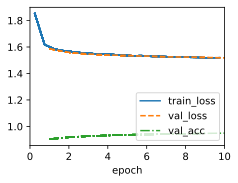

In [38]:

relu_256_model = MLPRelu(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(relu_256_model, data)
print(d2l.evaluate_accuracy(relu_256_model, data.val_dataloader()))

## Rede com 2 camadas escondidas

Além de podermos tornar a camada escondida maior, com o tempo de processamento que poupamos nos também possibilitamos a inserção de múltiplas camadas escondidas.

In [39]:
class MLPRelu2Hidden(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='relu'),
            tf.keras.layers.Dense(num_hiddens, activation='relu'),
            tf.keras.layers.Dense(num_outputs, activation='softmax')])
        self.loss_fn=tf.keras.losses.SparseCategoricalCrossentropy
        self.optimizer=tf.keras.optimizers.Adam

0.9613


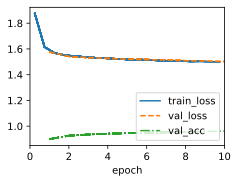

In [40]:

hidden_model = MLPRelu2Hidden(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(hidden_model, data)
print(d2l.evaluate_accuracy(hidden_model, data.val_dataloader()))

# Visualização dos resultados

Para a visualização dos resultados errados de cada modelo, fizemos procurar erros em cada mini batch criado e mostrar o erro até que a quantidade de erros seja 5, assim que chega nesse valor, ele para de procurar erros nos próximos mini batches. Assim, temos erros o suficiente para gerar conclusões necessárias para o nosso projeto.

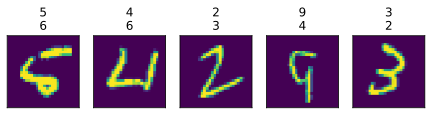

In [41]:
dados = iter(data.val_dataloader())
wX,wy,wpreds = [], [], []
count = 0
while len(wX)<5:
    X,y = next(dados)
    preds=tf.argmax(sigmoid_model(X),axis=1)
    wrong=tf.cast(preds,y.dtype)!=y
    [wX.append(i) for i in X[wrong]]
    [wy.append(i) for i in y[wrong]]
    [wpreds.append(i) for i in preds[wrong]]
    count+=len(X[wrong])
batch=[wX,wy]
labels=[f"{wy[i].numpy()}\n{wpreds[i].numpy()}" for i in range(len(wy))]
data.visualize(batch, labels=labels, ncols=len(wy))

### Você acha que é razoável que um humano cometesse esse tipo de erro?
Considerando os erros apresentados, o primeiro erro provavelmente pode ser cometido por um humano, mas os outros não acho que um humano conseguiria cometer.

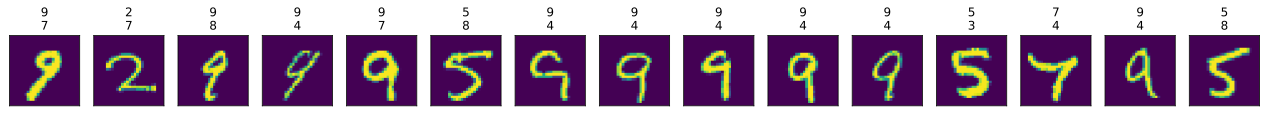

In [42]:
wX,wy,wpreds = [], [], []
count = 0
while len(wX)<5:
    X,y = next(dados)
    preds=tf.argmax(soft_model(X),axis=1)
    wrong=tf.cast(preds,y.dtype)!=y
    [wX.append(i) for i in X[wrong]]
    [wy.append(i) for i in y[wrong]]
    [wpreds.append(i) for i in preds[wrong]]
    count+=len(X[wrong])
batch=[wX,wy]
labels=[f"{wy[i].numpy()}\n{wpreds[i].numpy()}" for i in range(len(wy))]
data.visualize(batch, labels=labels, ncols=len(wy))

### Você acha que é razoável que um humano cometesse esse tipo de erro?
Considerando os erros apresentados, o quarto errado é provável de ser cometido por um ser humano, mas nenhum dos outros acho que podem ser cometidos.

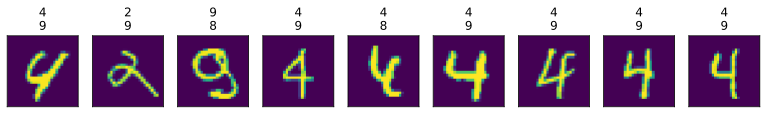

In [43]:
wX,wy,wpreds = [], [], []
count = 0
while len(wX)<5:
    X,y = next(dados)
    preds=tf.argmax(adam_model(X),axis=1)
    wrong=tf.cast(preds,y.dtype)!=y
    [wX.append(i) for i in X[wrong]]
    [wy.append(i) for i in y[wrong]]
    [wpreds.append(i) for i in preds[wrong]]
    count+=len(X[wrong])
batch=[wX,wy]
labels=[f"{wy[i].numpy()}\n{wpreds[i].numpy()}" for i in range(len(wy))]
data.visualize(batch, labels=labels, ncols=len(wy))

### Você acha que é razoável que um humano cometesse esse tipo de erro?
Considerando os erros apresentados, não acho que nenhum dos erros seja possível ser cometido por um ser humano.

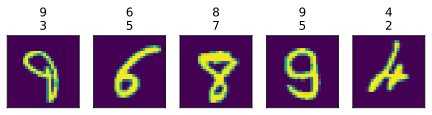

In [44]:
wX,wy,wpreds = [], [], []
count = 0
while len(wX)<5:
    X,y = next(dados)
    preds=tf.argmax(relu_model(X),axis=1)
    wrong=tf.cast(preds,y.dtype)!=y
    [wX.append(i) for i in X[wrong]]
    [wy.append(i) for i in y[wrong]]
    [wpreds.append(i) for i in preds[wrong]]
    count+=len(X[wrong])
batch=[wX,wy]
labels=[f"{wy[i].numpy()}\n{wpreds[i].numpy()}" for i in range(len(wy))]
data.visualize(batch, labels=labels, ncols=len(wy))

### Você acha que é razoável que um humano cometesse esse tipo de erro?
Considerando os erros apresentados, o último erro provavelmente pode ser cometidos por um ser humano, os outros não.

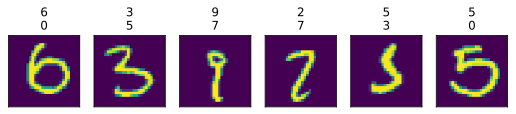

In [45]:
wX,wy,wpreds = [], [], []
count = 0
while len(wX)<5:
    X,y = next(dados)
    preds=tf.argmax(relu_256_model(X),axis=1)
    wrong=tf.cast(preds,y.dtype)!=y
    [wX.append(i) for i in X[wrong]]
    [wy.append(i) for i in y[wrong]]
    [wpreds.append(i) for i in preds[wrong]]
    count+=len(X[wrong])
batch=[wX,wy]
labels=[f"{wy[i].numpy()}\n{wpreds[i].numpy()}" for i in range(len(wy))]
data.visualize(batch, labels=labels, ncols=len(wy))

### Você acha que é razoável que um humano cometesse esse tipo de erro?
Considerando os erros apresentados, o quarto provavelmente seria cometido por um ser humano, os outros imagino que não.

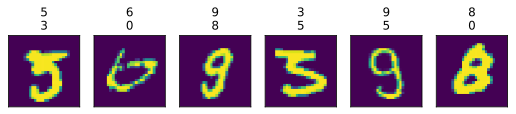

In [46]:
wX,wy,wpreds = [], [], []
count = 0
while len(wX)<5:
    X,y = next(dados)
    preds=tf.argmax(hidden_model(X),axis=1)
    wrong=tf.cast(preds,y.dtype)!=y
    [wX.append(i) for i in X[wrong]]
    [wy.append(i) for i in y[wrong]]
    [wpreds.append(i) for i in preds[wrong]]
    count+=len(X[wrong])
batch=[wX,wy]
labels=[f"{wy[i].numpy()}\n{wpreds[i].numpy()}" for i in range(len(wy))]
data.visualize(batch, labels=labels, ncols=len(wy))

#### Você acha que é razoável que um humano cometesse esse tipo de erro?
Considerando os erros apresentados, os quatro primeiros erros seriam possivelmente cometidos por seres humanos, os últimos dois não.

# Matriz de confusão

Uma matriz de confusão é uma ferramenta usada para avaliar o desempenho de modelos de classificação. Ela é uma tabela que compara as previsões do modelo com os valores reais. Os dados obtidos com essa matriz são muito importantes para avaliar como seu modelo está se comportando e para análises futuras como *Previsão*, *Sensibilidade*, *F1-Score* e etc. Com ela é possível analisar padrões de erros e fazer uma análise de como corrigir esse desbalanceamento.

Para a matriz que foi feita abaixo, utilizamos o nosso melhor modelo (A rede com 2 camadas escondidas). Cada linha da matriz representa as classes reais, e cada coluna representa as classes preditas. Os elementos da matriz mostram a quantidade de vezes que uma classe foi predita como outra.



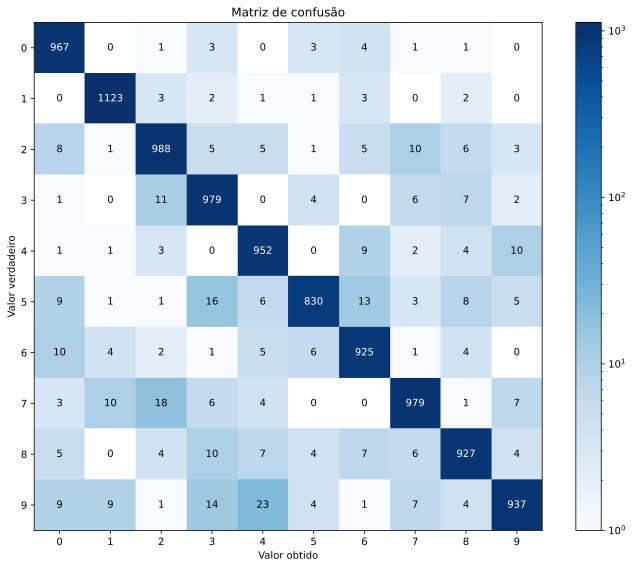

In [48]:
X,y = data.val
preds=tf.argmax(hidden_model(X),axis=1)
wrong=tf.cast(preds,y.dtype)!=y
cm = confusion_matrix(y,preds)
plt.figure(figsize=(10, 8)) 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, norm=LogNorm())
plt.title("Matriz de confusão")
plt.colorbar()

tick_marks = range(len(cm))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2. else "black")

plt.ylabel("Valor verdadeiro")
plt.xlabel("Valor obtido")
plt.tight_layout()
plt.show()



### As confusões mais comuns para cada classe são:
- Classe 0: A maior confusão em relação ao 0 foi o número 6, o que faz sentido considerando que os dois possuem um círculo.
- Classe 1: A maior confusão em relação ao 1 foi o número 2, o que não faz muito sentido, porque parando pra pensar, imagina-se que a maior confusão viria do 7.
- Classe 2: A maior confusão em relação ao 2 foi o número 7, o que faz sentido pensando que se puxar uma perna no 7, vira quase um 2.
- Classe 3: A maior confusão em relação ao 3 foi o número 2, o que não faz muito sentido, porque parando pra pensar, imagina-se que a maior confusão viria do 8.
- Classe 4: A maior confusão em relação ao 4 foi o número 9, o que faz sentido considerando que se fechar a parte de cima do 4 vira um 9.
- Classe 5: A maior confusão em relação ao 5 foi o número 3, o que faz sentido se colocar os dois números lado a lado, não fica tão distante.
- Classe 6: A maior confusão em relação ao 6 foi o número 0, o que faz sentido pensando na mesma explicação do 0 anteriormente.
- Classe 7: A maior confusão em relação ao 7 foi o número 2, o que faz sentido pensando na mesma explicação do 2 anteriormente.
- Classe 8: A maior confusão em relação ao 8 foi o número 3, o que faz sentido pensando que se fechar o 3 vira um 8.
- Classe 9: A maior confusão em relação ao 9 foi o número 4, o que faz sentido pensando na mesma explicação do 4 anteriormente.
